## Problem Statement

Banks issue loans based on a customer’s financial history, but early risk signals are often hidden inside day-to-day account activity like transactions, balances, and recurring payments. When these signals are missed, the bank ends up approving loans for customers who later struggle to repay, leading to higher defaults and financial loss.

In this project, the goal is to build a structured loan risk dataset from raw banking data (accounts, clients, transactions, orders, cards, and district-level demographics) and use it to identify which loan customers are likely to default. The challenge is that the data is stored across multiple tables and contains inconsistencies in date formats, missing values, and relational dependencies that must be cleaned and validated before analysis.

The final outcome is an ML-ready master dataset where each loan is enriched with customer behavior features such as transaction activity, balance patterns, repayment pressure, and region-level indicators—so loan risk can be predicted more accurately and consistently.

## Objective:
Understand loan data, validate quality, and identify risk drivers that influence the target (loan status / default behavior).

### Load Data set

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector as connection
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Load dataset
sql = ("SELECT * FROM loan_master;")
mydb = connection.connect(host = "localhost",database = 'cap_prj',user = "root",passwd = "Dnyanesh@123",use_pure = True)
df = pd.read_sql(sql,mydb)


### 1A) Dataset Overview

In [49]:
# Basic shape
print("Shape of Data")
print("Rows, Columns:", df.shape)

# Column summary
print("Column Summary\n")
display(df.head())
display(df.info())

# Numerical + categorical split
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numerical Columns:", len(num_cols))

print("Categorical Columns:", len(cat_cols))

# Unique count per column
unique_counts = df.nunique().sort_values(ascending=False)
display(unique_counts.head(15))


Shape of Data
Rows, Columns: (682, 37)
Column Summary



,Loan_ID,Account_ID,Loan_Date,Loan_Amount,Duration,Payments,Status,Frequency,Account_Date,Client_ID,Owner_Count,User_Count,Is_Joint_Account,Txn_Count,Active_Days,Avg_Trans_Amount,Total_Trans_Amount,Avg_Balance,Balance_Volatility,Total_Credit,Total_Debit,Net_Cashflow,Order_Count,Total_Order_Amount,Avg_Order_Amount,Card_Count,Has_Card,Gold_Card_Count,District_Name,Region,Avg_Salary,Unemployment_Rate_1,Unemployment_Rate_2,Avg_Unemployment_Rate,Entrepreneurs_Per_1000,Crimes_1,Crimes_2
0,5314,1787,1993-07-05,96396,12,8033,B,POPLATEK TYDNE,1993-03-22,2166,1.0000,0.0000,0,8,8,"11,427.7500","91,422.0000","29,542.5000","19,439.7300","91,422.0000",0.0000,"91,422.0000",1,"8,033.2000","8,033.2000",0,0,0.0000,Sokolov,west Bohemia,"9,650.0000",3.3800,3.6700,3.5250,100.0000,"2,985.0000","2,804.0000"
1,5316,1801,1993-07-11,165960,36,4610,A,POPLATEK MESICNE,1993-02-13,2181,1.0000,0.0000,0,51,41,"11,023.8600","562,217.0000","53,611.3900","25,629.0300","562,217.0000",0.0000,"562,217.0000",4,"13,152.0000","3,288.0000",0,0,0.0000,Nachod,east Bohemia,"8,369.0000",1.7900,2.3100,2.0500,117.0000,"2,854.0000","2,618.0000"
2,5325,1843,1993-08-03,105804,36,2939,A,POPLATEK MESICNE,1993-01-30,2235,1.0000,0.0000,0,32,27,"8,106.3800","259,404.0000","38,768.9100","14,020.4800","259,404.0000",0.0000,"259,404.0000",2,"9,932.7000","4,966.3500",1,1,0.0000,Pribram,central Bohemia,"8,754.0000",3.8300,4.3100,4.0700,137.0000,"3,804.0000","3,868.0000"
3,5523,2705,1993-12-08,93888,36,2608,A,POPLATEK PO OBRATU,1993-07-05,3264,1.0000,0.0000,0,6,6,"6,246.0000","37,476.0000","21,610.8300","12,895.4000","37,476.0000",0.0000,"37,476.0000",2,"13,331.2000","6,665.6000",0,0,0.0000,Vyskov,south Moravia,"8,288.0000",3.7900,4.5200,4.1550,110.0000,"1,562.0000","1,460.0000"
4,4959,2,1994-01-05,80952,24,3373,A,POPLATEK MESICNE,1993-02-26,2,1.0000,0.0000,1,24,23,"10,294.9200","247,078.0000","37,852.4600","13,719.9300","247,078.0000",0.0000,"247,078.0000",2,"10,638.7000","5,319.3500",0,0,0.0000,Hl.m. Praha,Prague,"12,541.0000",0.2900,0.4300,0.3600,167.0000,"85,677.0000","99,107.0000"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Loan_ID                 682 non-null    int64  
 1   Account_ID              682 non-null    int64  
 2   Loan_Date               682 non-null    object 
 3   Loan_Amount             682 non-null    int64  
 4   Duration                682 non-null    int64  
 5   Payments                682 non-null    int64  
 6   Status                  682 non-null    object 
 7   Frequency               682 non-null    object 
 8   Account_Date            682 non-null    object 
 9   Client_ID               682 non-null    int64  
 10  Owner_Count             682 non-null    float64
 11  User_Count              682 non-null    float64
 12  Is_Joint_Account        682 non-null    int64  
 13  Txn_Count               682 non-null    int64  
 14  Active_Days             682 non-null    in

None

Numerical Columns: 31
Categorical Columns: 6


Loan_ID               682
Account_ID            682
Client_ID             682
Avg_Order_Amount      651
Total_Order_Amount    649
Loan_Amount           645
Payments              577
Loan_Date             559
Account_Date          557
Avg_Trans_Amount       99
Total_Credit           99
Avg_Balance            99
Total_Trans_Amount     99
Net_Cashflow           99
Balance_Volatility     93
dtype: int64

#### Conclusion (Business Meaning)

We confirmed dataset structure (rows/cols), identified numerical vs categorical features, and checked uniqueness to detect high-cardinality columns that may require encoding or grouping

### 1B) Univariate Analysis

##### Numerical Summary

Numerical descriptive stats:



,count,mean,std,min,25%,50%,75%,max
Loan_ID,682.0000,"6,172.4663",682.5793,"4,959.0000","5,577.5000","6,176.5000","6,752.5000","7,308.0000"
Account_ID,682.0000,"5,824.1628","3,283.5127",2.0000,"2,967.0000","5,738.5000","8,686.0000","11,362.0000"
Loan_Amount,682.0000,"151,410.1760","113,372.4063","4,980.0000","66,732.0000","116,928.0000","210,654.0000","590,820.0000"
Duration,682.0000,36.4927,17.0752,12.0000,24.0000,36.0000,48.0000,60.0000
Payments,682.0000,"4,190.6642","2,215.8303",304.0000,"2,477.0000","3,934.0000","5,813.5000","9,910.0000"
Client_ID,682.0000,"7,120.5733","4,059.1206",2.0000,"3,582.2500","6,941.0000","10,711.0000","13,971.0000"
Owner_Count,682.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
User_Count,682.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Is_Joint_Account,682.0000,0.2126,0.4095,0.0000,0.0000,0.0000,0.0000,1.0000
Txn_Count,682.0000,2.4487,7.9126,0.0000,0.0000,0.0000,0.0000,52.0000



 Skewness:


Gold_Card_Count      6.3106
Total_Credit         4.8286
Total_Trans_Amount   4.8286
Net_Cashflow         4.8286
Txn_Count            3.8507
Active_Days          3.6318
Avg_Trans_Amount     2.9589
Avg_Balance          2.9358
Balance_Volatility   2.8925
Crimes_2             2.2044
dtype: float64


 Histogram Plot:


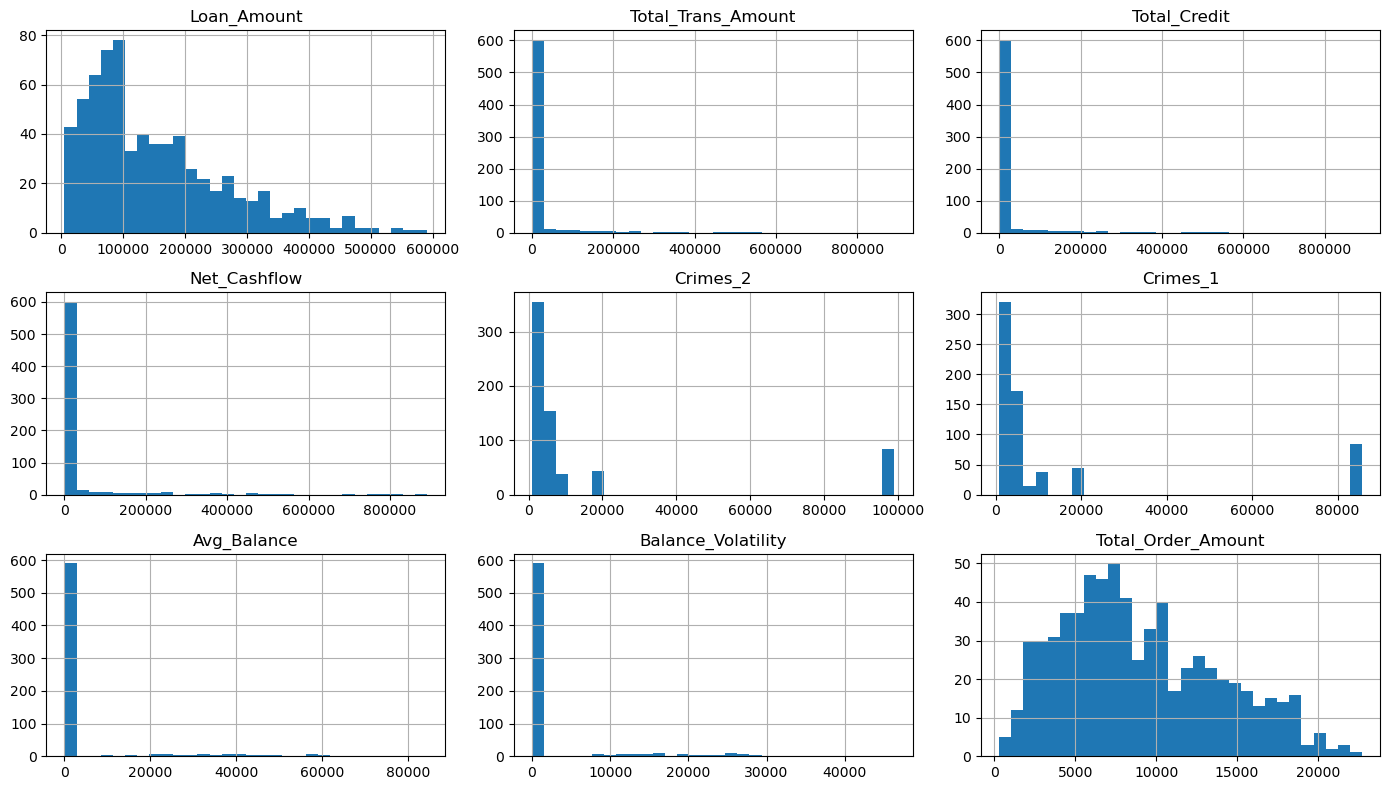

In [50]:
# Numerical descriptive stats
print("Numerical descriptive stats:\n")
display(df[num_cols].describe().T)

# Skewness check (important for amount-like variables)
print("\n Skewness:")
skewness = df[num_cols].skew(numeric_only=True).sort_values(ascending=False)
display(skewness.head(10))

# Histograms (top variance features)
print("\n Histogram Plot:")
top_numeric = df[num_cols].var().sort_values(ascending=False).head(9).index
df[top_numeric].hist(bins=30, figsize=(14, 8))
plt.tight_layout()
plt.show()


#### Conclusion

Most financial/transaction-related variables tend to be skewed (not normal), meaning models may benefit from log transforms or robust scaling to avoid domination by extreme values.

##### Categorical Summary

In [51]:
# Cardinality check
cardinality = df[cat_cols].nunique().sort_values(ascending=False)
display(cardinality)

# Category distribution (top 10 for each)
for col in cat_cols:
    print(f"\n--- {col} ---")
    display(df[col].value_counts(dropna=False).head(10))


Loan_Date        559
Account_Date     557
District_Name     76
Region             8
Status             4
Frequency          3
dtype: int64


--- Loan_Date ---


Loan_Date
1997-12-28    4
1998-04-19    4
1998-07-12    4
1997-08-15    3
1997-06-19    3
1994-12-21    3
1997-09-07    3
1996-10-29    3
1997-05-03    3
1997-12-08    3
Name: count, dtype: int64


--- Status ---


Status
C    403
A    203
D     45
B     31
Name: count, dtype: int64


--- Frequency ---


Frequency
POPLATEK MESICNE      559
POPLATEK TYDNE         91
POPLATEK PO OBRATU     32
Name: count, dtype: int64


--- Account_Date ---


Account_Date
1996-07-08    4
1993-11-26    4
1996-06-08    4
1997-08-08    4
1996-08-19    3
1996-12-30    3
1995-11-09    3
1993-05-20    3
1996-03-06    3
1993-09-13    3
Name: count, dtype: int64


--- District_Name ---


District_Name
Hl.m. Praha        84
Karvina            24
Brno - mesto       24
Ostrava - mesto    20
Zlin               17
Frydek - Mistek    16
Prachatice         14
Usti nad Orlici    14
Olomouc            14
Louny              13
Name: count, dtype: int64


--- Region ---


Region
south Moravia      129
north Moravia      109
central Bohemia     90
Prague              84
east Bohemia        84
north Bohemia       61
south Bohemia       60
west Bohemia        57
None                 8
Name: count, dtype: int64

### Conclusion

Categorical variables contain varying cardinality, so rare categories should be grouped to improve model generalization and avoid unstable segment-level insights.

## 1C) Target Variable Understanding

Status
C    403
A    203
D     45
B     31
Name: count, dtype: int64

Target distribution (%):
Status
C   59.0900
A   29.7700
D    6.6000
B    4.5500
Name: proportion, dtype: float64


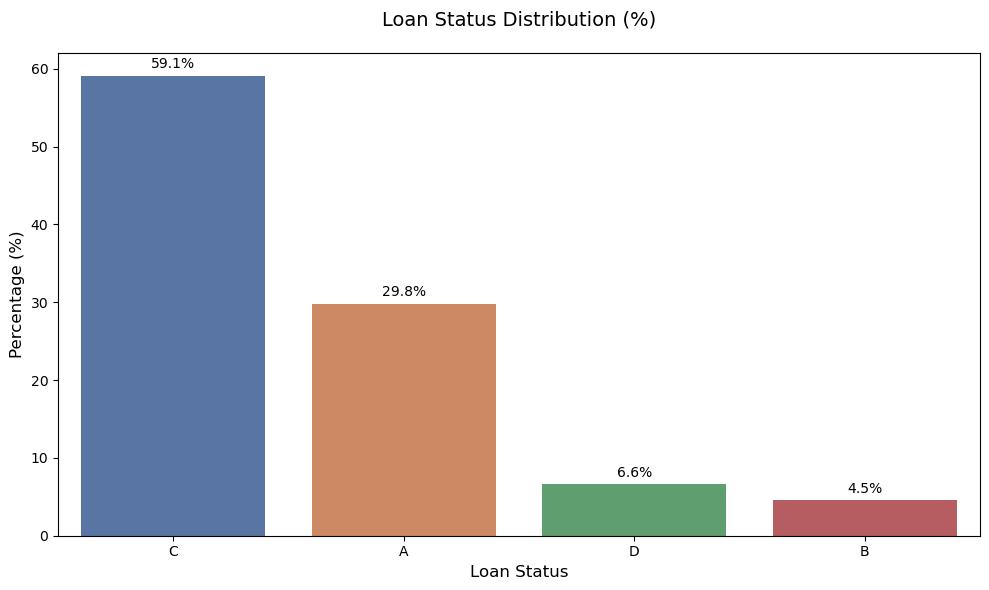

In [52]:
target_col = "Status" 

print(df[target_col].value_counts(dropna=False))
print("\nTarget distribution (%):")
print(round(df[target_col].value_counts(normalize=True) * 100, 2))


# Plot 1: Loan Status Distribution
fig, ax = plt.subplots(figsize=(10, 6)) 
status_pct = df[target_col].value_counts(normalize=True) * 100
status_colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52']

ax = sns.barplot(
    x=status_pct.index,
    y=status_pct.values,
    palette=status_colors,
)

ax.set_title("Loan Status Distribution (%)", fontsize=14, pad=20)  # Padding
ax.set_xlabel("Loan Status", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)

for i, v in enumerate(status_pct.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()

#### Conclusion

Missing values exist but at low percentage. We will impute safely and keep missing flags because missingness may carry predictive information (data not missing completely at random).

#### Target distribution + binary default

In [53]:
if target_col:
    df[target_col] = df[target_col].astype(str).str.strip().str.upper()
    
    # Business logic: Default = {B, D}
    df["is_default"] = df[target_col].isin(["B", "D"]).astype(int)
    df['is_bad_loan'] = df['Status'].isin(['A','C']).astype(int)
    df["Loan_Quality"] = np.where(df["is_default"] == 1, "Bad", "Good")
    print("\nDefault Rate (%):", round(df["is_default"].mean() * 100, 2))
else:
    print("status column not found. You must confirm your target.")



Default Rate (%): 11.14


#### Overall Default Rate (Business KPI)

In [54]:
default_rate = df["is_default"].mean() * 100
good_rate = 100 - default_rate

print(f"Default Rate: {default_rate:.2f}%")
print(f"Good Rate: {good_rate:.2f}%")


Default Rate: 11.14%
Good Rate: 88.86%


In [55]:
df['Loan_Quality'].value_counts()

Loan_Quality
Good    606
Bad      76
Name: count, dtype: int64

## 2A) Missing Values

In [56]:
missing = df.isna().sum()
missing_pct = round((missing / len(df)) * 100, 2)

missing_table = pd.DataFrame({
    "missing_count": missing,
    "missing_pct": missing_pct
}).query("missing_count > 0").sort_values("missing_pct", ascending=False)

display(missing_table)


,missing_count,missing_pct
District_Name,8,1.1700
Region,8,1.1700
Avg_Salary,8,1.1700
Unemployment_Rate_1,8,1.1700
Unemployment_Rate_2,8,1.1700
Avg_Unemployment_Rate,8,1.1700
Entrepreneurs_Per_1000,8,1.1700
Crimes_1,8,1.1700
Crimes_2,8,1.1700


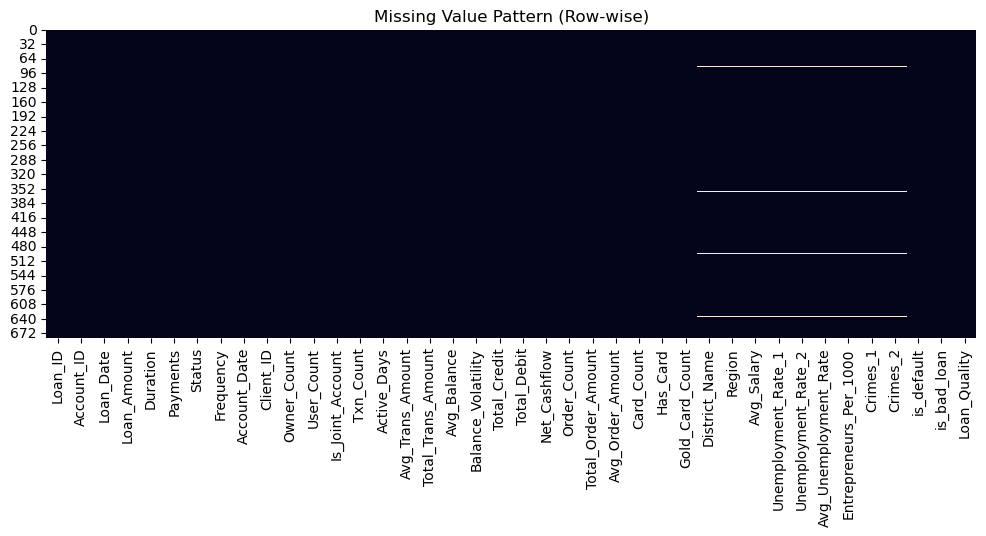

In [57]:
# Heatmap of missingness
plt.figure(figsize=(12,4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Value Pattern (Row-wise)")
plt.show()


#### Conclusion

Missing values exist but at low percentage. We will impute safely and keep missing flags because missingness may carry predictive information (data not missing completely at random).

## 2B) Duplicates (Row + Key )

In [58]:
# Duplicate rows
dup_rows = df.duplicated().sum()
print("Duplicate rows:", dup_rows)

# Duplicate Loan IDs (if Loan_ID should be unique)
if "Loan_ID" in df.columns:
    dup_loan_id = df["Loan_ID"].duplicated().sum()
    print("Duplicate Loan_ID:", dup_loan_id)


Duplicate rows: 0
Duplicate Loan_ID: 0


#### Conclusion

We validated dataset uniqueness. Duplicate rows or duplicate primary IDs indicate join explosion or repeated observations and must be resolved before modeling.

## 2C) Outliers (IQR + Z-score + Boxplot)

#### IQR Outlier Detection

In [59]:
def iqr_outlier_summary(data, cols):
    outlier_summary = []
    for col in cols:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = ((data[col] < lower) | (data[col] > upper)).sum()
        outlier_summary.append((col, outliers, round(outliers/len(data)*100,2)))
    return pd.DataFrame(outlier_summary, columns=["feature","outlier_count","outlier_pct"]).sort_values("outlier_pct", ascending=False)

outlier_table = iqr_outlier_summary(df, num_cols)
display(outlier_table.head(10))


,feature,outlier_count,outlier_pct
21,Card_Count,170,24.9300
22,Has_Card,170,24.9300
8,Is_Joint_Account,145,21.2600
29,Crimes_1,128,18.7700
30,Crimes_2,128,18.7700
12,Total_Trans_Amount,101,14.8100
10,Active_Days,101,14.8100
11,Avg_Trans_Amount,101,14.8100
13,Avg_Balance,101,14.8100
17,Net_Cashflow,101,14.8100


#### Boxplot

<Figure size 1400x600 with 0 Axes>

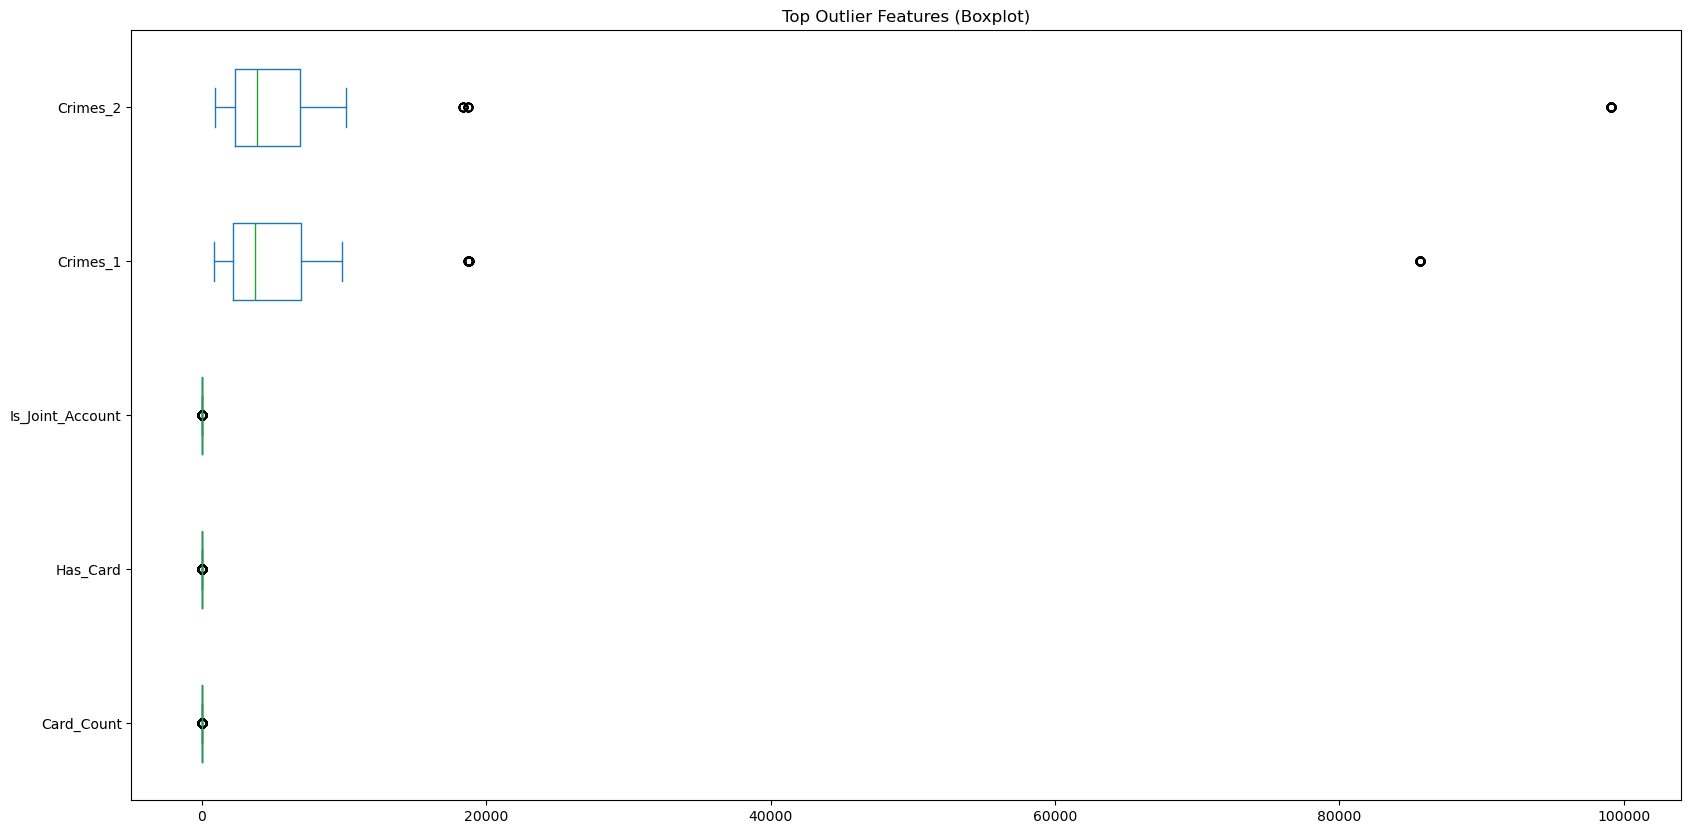

In [60]:
top_outlier_feats = outlier_table.head(5)["feature"].tolist()

plt.figure(figsize=(14,6))
df[top_outlier_feats].plot(kind="box", vert=False)
plt.title("Top Outlier Features (Boxplot)", fontsize = 12)
plt.show()


#### Conclusion

Outliers are expected in loan/transaction datasets (high-value customers, risky behavior, fraud patterns). We should not remove them blindly—better approach is capping/winsorization or log-transform after validation.

## 2D) Datatype Issues

In [61]:
# Check datatypes
dtype_table = df.dtypes.sort_values()
display(dtype_table)

# Convert date columns safely if present
for col in df.columns:
    if "date" in col.lower():
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Re-check
display(df.dtypes)


Loan_ID                     int64
Card_Count                  int64
is_bad_loan                 int64
Has_Card                    int64
Active_Days                 int64
Txn_Count                   int64
Is_Joint_Account            int64
Client_ID                   int64
Order_Count                 int64
Payments                    int64
Duration                    int64
Loan_Amount                 int64
is_default                  int64
Account_ID                  int64
Crimes_1                  float64
Avg_Unemployment_Rate     float64
Avg_Order_Amount          float64
Crimes_2                  float64
Unemployment_Rate_1       float64
Avg_Salary                float64
Gold_Card_Count           float64
Entrepreneurs_Per_1000    float64
Unemployment_Rate_2       float64
Total_Credit              float64
Net_Cashflow              float64
Total_Debit               float64
Balance_Volatility        float64
Avg_Balance               float64
Total_Trans_Amount        float64
Avg_Trans_Amou

Loan_ID                            int64
Account_ID                         int64
Loan_Date                 datetime64[ns]
Loan_Amount                        int64
Duration                           int64
Payments                           int64
Status                            object
Frequency                         object
Account_Date              datetime64[ns]
Client_ID                          int64
Owner_Count                      float64
User_Count                       float64
Is_Joint_Account                   int64
Txn_Count                          int64
Active_Days                        int64
Avg_Trans_Amount                 float64
Total_Trans_Amount               float64
Avg_Balance                      float64
Balance_Volatility               float64
Total_Credit                     float64
Total_Debit                      float64
Net_Cashflow                     float64
Order_Count                        int64
Total_Order_Amount               float64
Avg_Order_Amount

#### Conclusion

We verified datatype correctness, especially dates. Correct datatypes are required for time-based trends, sorting, and feature engineering such as tenure or monthly cohort risk.

## 2E) Data Leakage / Suspicious Columns

In [62]:
leakage_keywords = ["status", "default", "payment_done", "closed", "paid", "outcome"]

suspect_cols = [c for c in df.columns if any(k in c.lower() for k in leakage_keywords)]
print("Potential leakage columns:", suspect_cols)


Potential leakage columns: ['Status', 'is_default']


#### Conclusion

We checked for leakage features that might directly reveal the outcome. Such features artificially inflate model accuracy but fail in production, so they must be removed or validated against prediction-time availability.

##  Dataset Grain Validation 

In [63]:
possible_keys = ["Loan_ID", "loan_id", "LOAN_ID"]
grain_col = next((c for c in possible_keys if c in df.columns), None)

grain_col

if grain_col:
    print("Grain column:", grain_col)
    print("Unique Loan_ID:", df[grain_col].nunique())
    print("Total rows:", len(df))
    print("Duplicates:", df.duplicated(subset=[grain_col]).sum())
else:
    print("❌ Loan_ID not found — decide correct business key for grain.")


Grain column: Loan_ID
Unique Loan_ID: 682
Total rows: 682
Duplicates: 0


### Conclusion:
Grain validation confirms whether the dataset is one row per loan.
- If duplicates exist → it indicates join explosion (1-to-many join leakage) and must be fixed before modeling.
- If Loan_ID is unique → dataset is clean and reliable for supervised learning.

In [64]:
if grain_col:
    row_per_key = df.groupby(grain_col).size().sort_values(ascending=False)
    print("Max rows per Loan_ID:", row_per_key.max())
    row_per_key.head(10)


Max rows per Loan_ID: 1


## 3A) Bivariate Analysis (Feature Relationship with Target) 

#### Numerical features vs Target (boxplot)

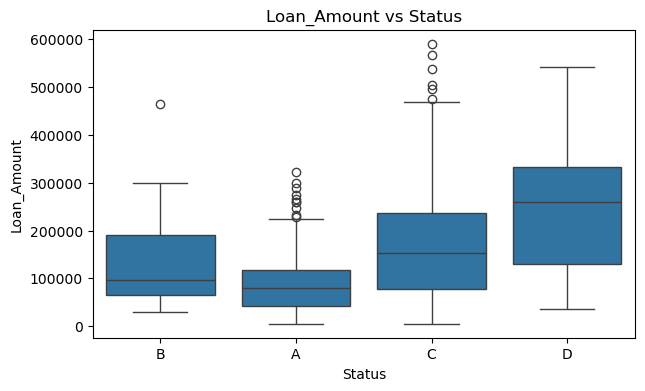

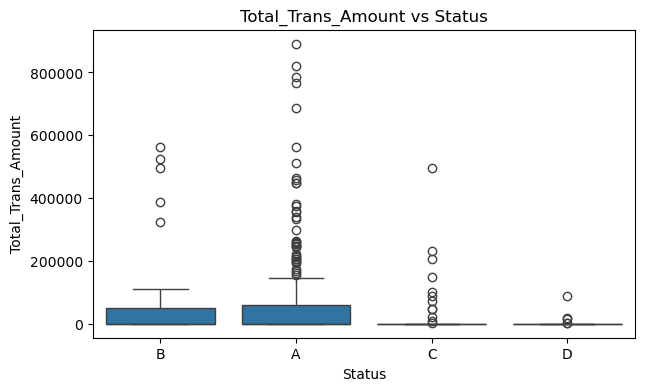

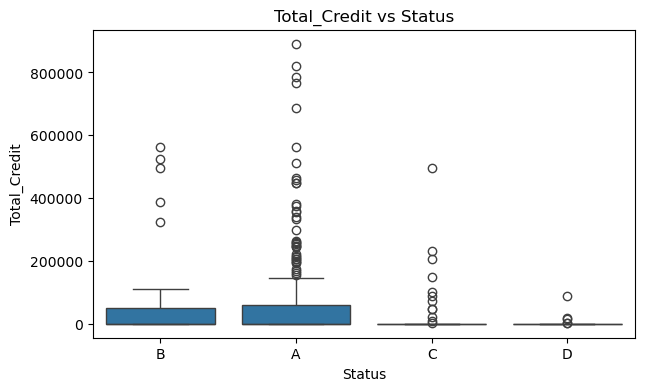

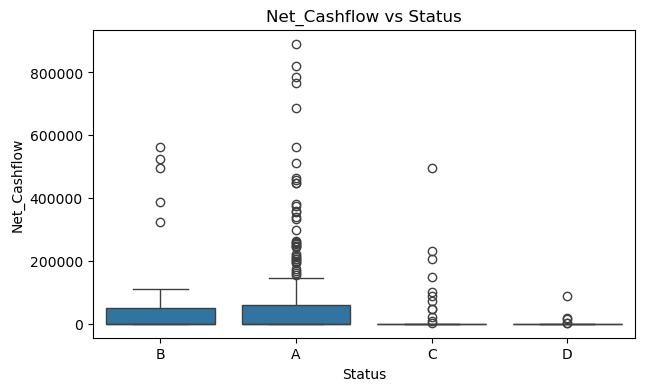

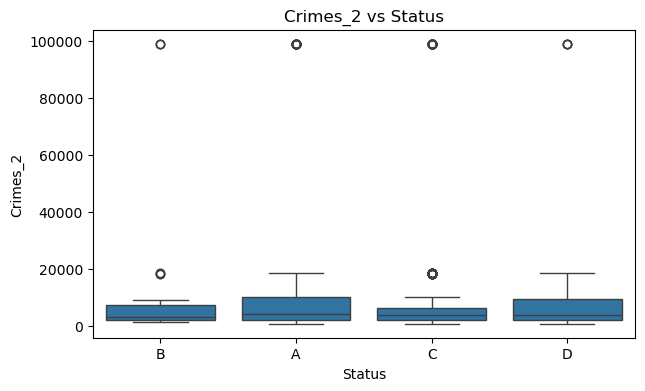

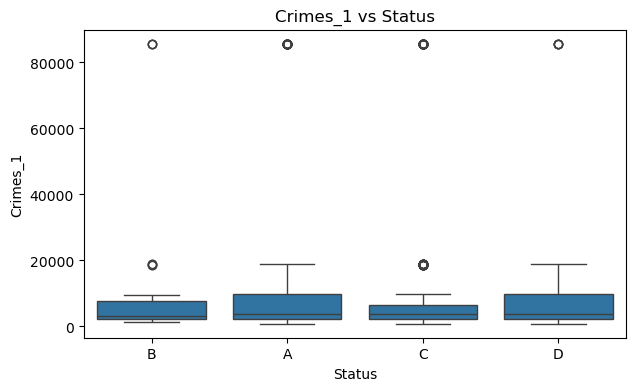

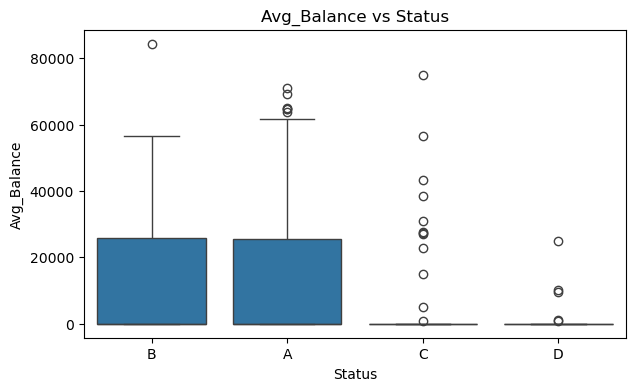

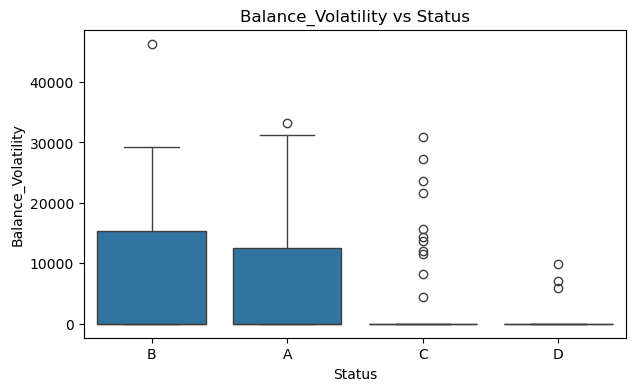

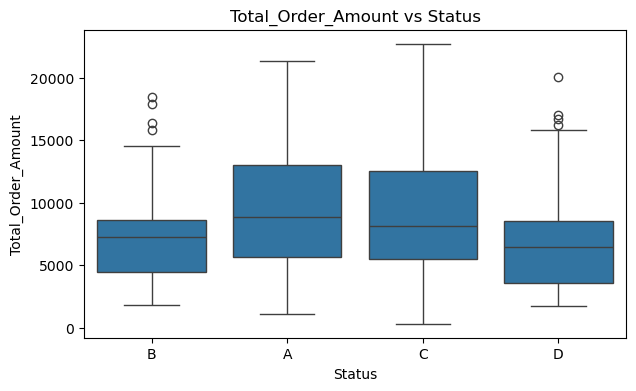

In [65]:
# Pick top numeric features for visualization
important_num = top_numeric.tolist()

for col in important_num:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df[target_col], y=df[col])
    plt.title(f"{col} vs {target_col}")
    plt.show()


#### Conclusion

Numeric distributions differ across target classes, indicating predictive signal. These features are candidates for modeling and for business interventions (risk rules / monitoring).

#### Categorical features vs Target - default rate bar chart

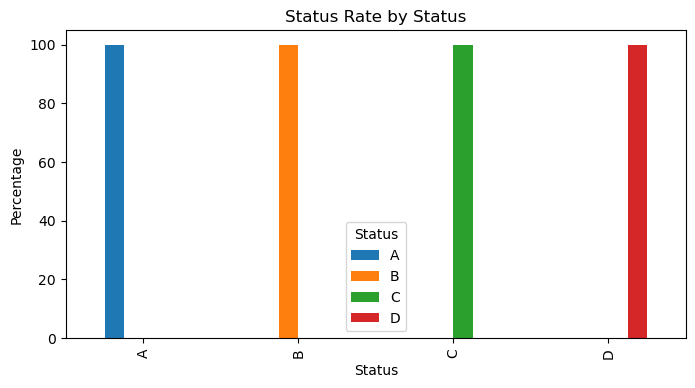

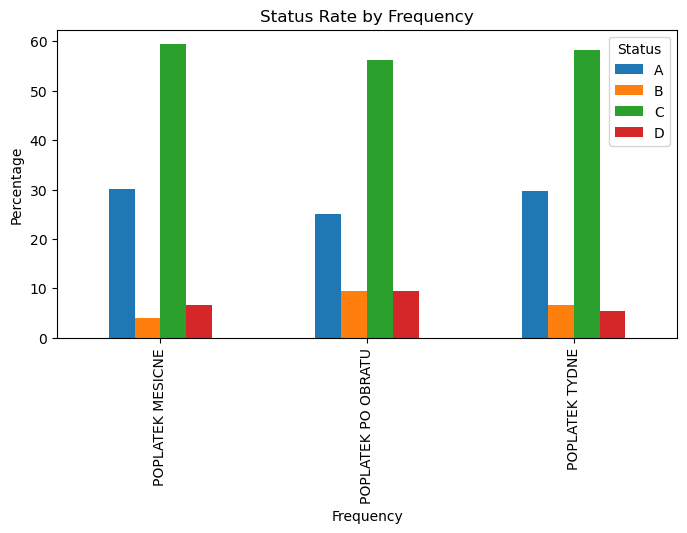

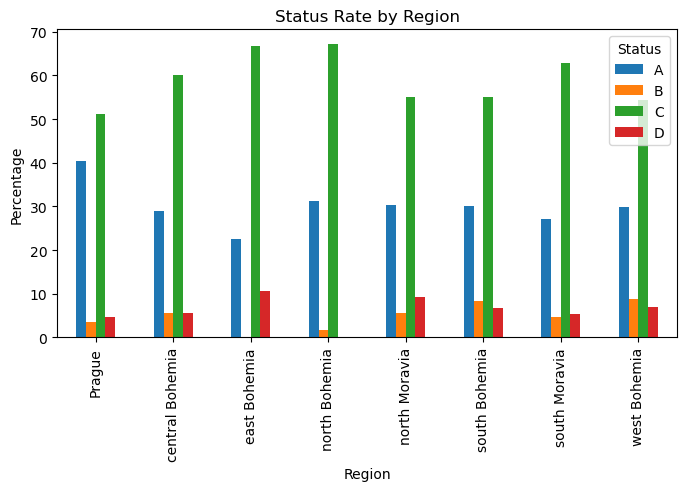

In [66]:
for col in cat_cols:
    if df[col].nunique() <= 15:  # avoid huge charts
        rate = pd.crosstab(df[col], df[target_col], normalize="index") * 100
        
        rate.plot(kind="bar", figsize=(8,4))
        plt.title(f"{target_col} Rate by {col}")
        plt.ylabel("Percentage")
        plt.show()


#### Conclusion

Certain categories show significantly different target rates. This reveals actionable segments (high-risk groups) and helps define policy-based decisions like stricter approval or monitoring.

## 3B) Correlation + Multicollinearity

##### Correlation Heatmap

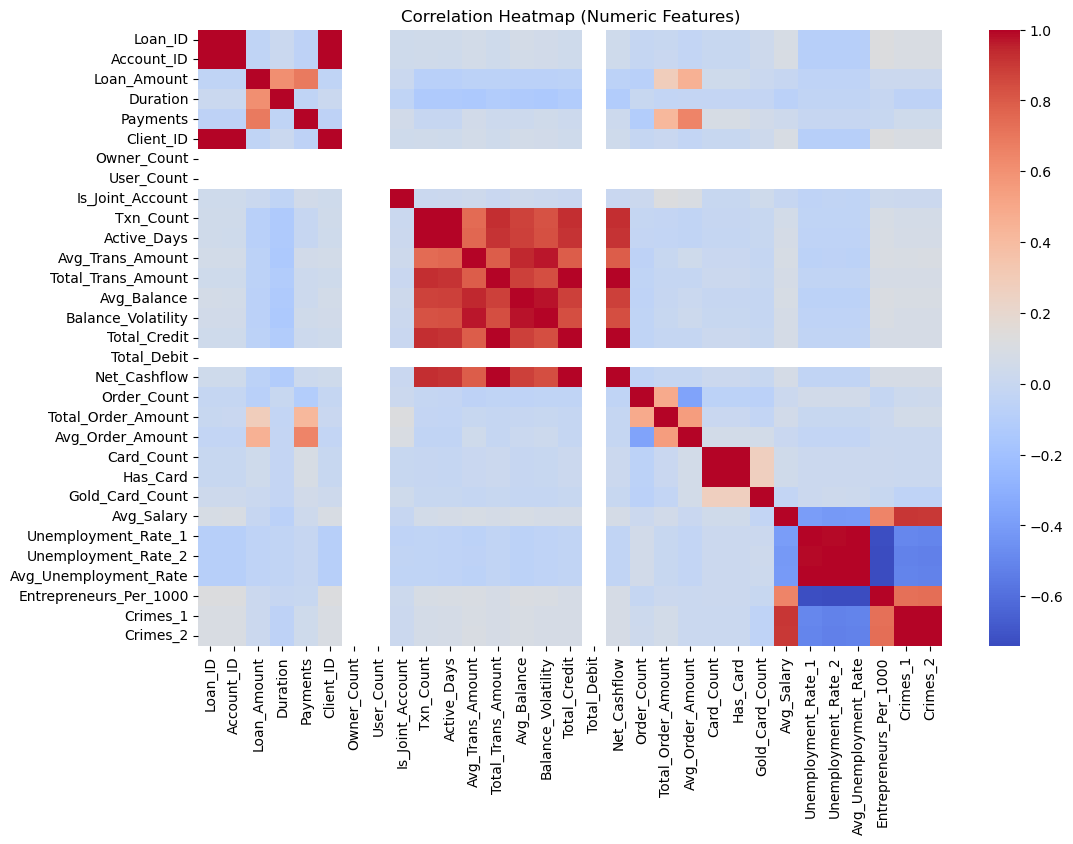

In [67]:
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


##### High correlation pairs table

In [73]:
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

display(corr_pairs.head(10))


Card_Count           Has_Card                1.0000
Total_Credit         Net_Cashflow            1.0000
Total_Trans_Amount   Total_Credit            1.0000
                     Net_Cashflow            1.0000
Account_ID           Client_ID               0.9999
Loan_ID              Account_ID              0.9999
Crimes_1             Crimes_2                0.9997
Loan_ID              Client_ID               0.9996
Unemployment_Rate_2  Avg_Unemployment_Rate   0.9977
Unemployment_Rate_1  Avg_Unemployment_Rate   0.9971
dtype: float64

#### Conclusion

We identified correlated/redundant signals. For stable models, we can drop one of highly correlated features or control with regularization to reduce noise and improve interpretability.

## 3C) Segment-level Insights

In [69]:
# Example: risk rate by region-like column
segment_col = None
for c in df.columns:
    if "region" in c.lower():
        segment_col = c

if segment_col:
    segment_risk = pd.crosstab(df[segment_col], df[target_col], normalize="index") * 100
    display(segment_risk.sort_values(segment_risk.columns[-1], ascending=False).head(10))


Status,A,B,C,D
Region,,,,
east Bohemia,22.6190,0.0000,66.6667,10.7143
north Moravia,30.2752,5.5046,55.0459,9.1743
west Bohemia,29.8246,8.7719,54.3860,7.0175
south Bohemia,30.0000,8.3333,55.0000,6.6667
central Bohemia,28.8889,5.5556,60.0000,5.5556
south Moravia,27.1318,4.6512,62.7907,5.4264
Prague,40.4762,3.5714,51.1905,4.7619
north Bohemia,31.1475,1.6393,67.2131,0.0000


#### Conclusion

Segment-level risk patterns highlight where defaults concentrate. This supports business actions like region-based lending policies, stricter credit verification, or targeted risk monitoring.

## 3D) Trends over time

##### Loan issuance trend + target trend

Rows after date cleaning: (682, 40)


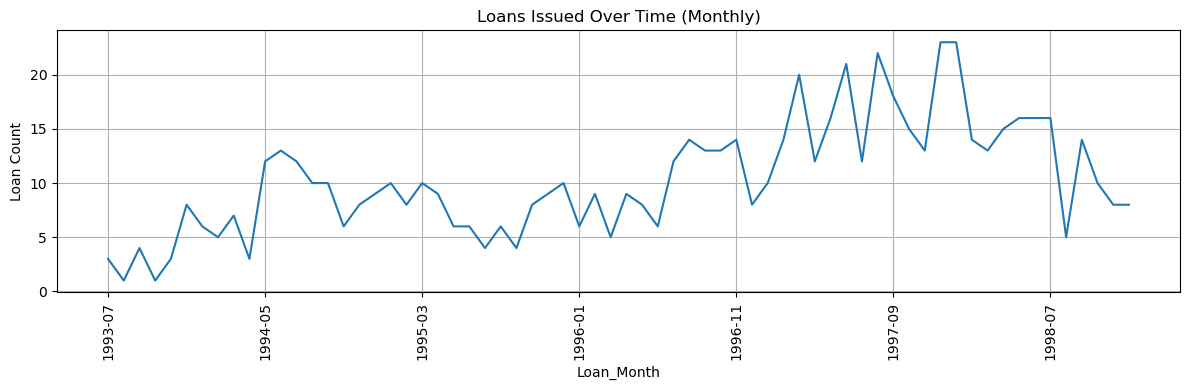

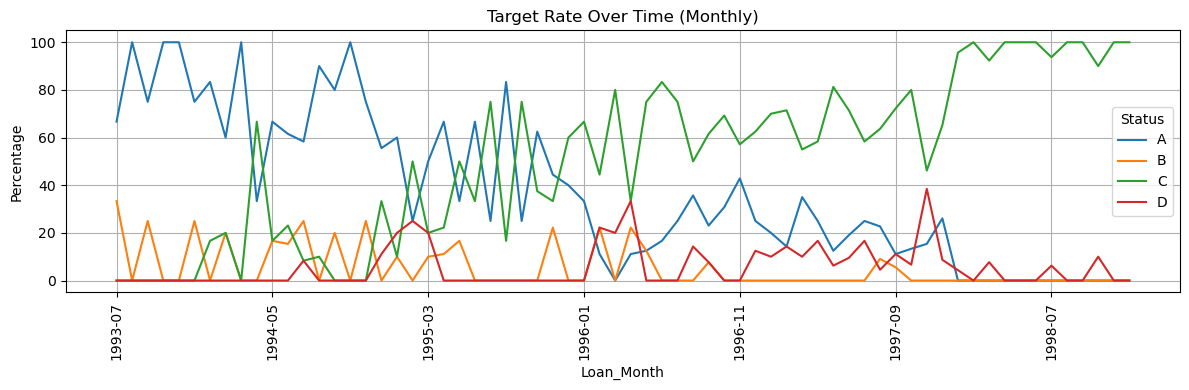

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Convert to datetime safely
df["Loan_Date"] = pd.to_datetime(df["Loan_Date"], errors="coerce")

# 2) Drop rows where Loan_Date is missing
df2 = df.dropna(subset=["Loan_Date"]).copy()
print("Rows after date cleaning:", df2.shape)

# 3) Create Month column
df2["Loan_Month"] = df2["Loan_Date"].dt.to_period("M").astype(str)

# 4) Loans count over time (sorted)
monthly_count = df2.groupby("Loan_Month").size().sort_index()

plt.figure(figsize=(12,4))
monthly_count.plot(kind="line", title="Loans Issued Over Time (Monthly)")
plt.ylabel("Loan Count")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Target distribution over time (sorted)
df2[target_col] = df2[target_col].astype(str).fillna("missing")

monthly_target = (
    pd.crosstab(df2["Loan_Month"], df2[target_col], normalize="index") * 100
).sort_index()

ax = monthly_target.plot(figsize=(12,4), title="Target Rate Over Time (Monthly)")
ax.set_ylabel("Percentage")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


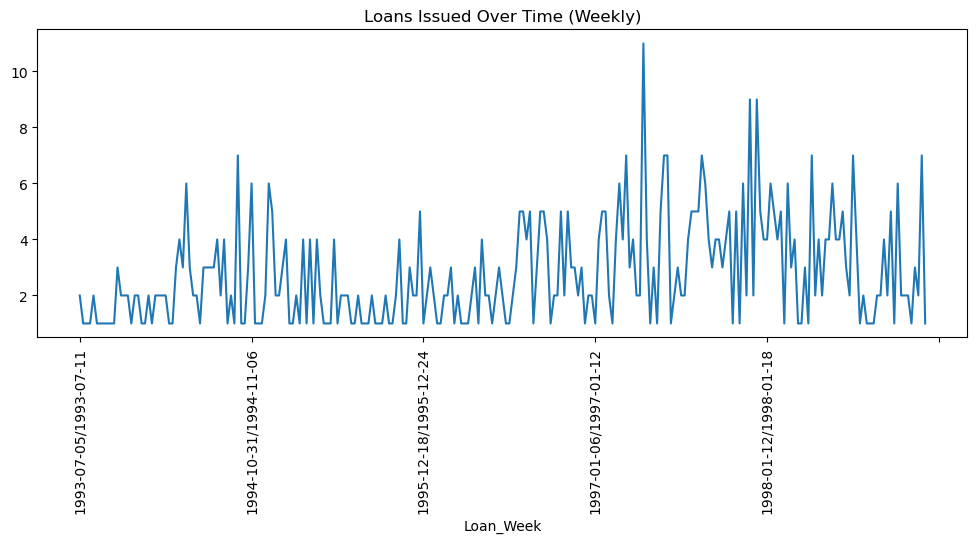

In [77]:
df2["Loan_Week"] = df2["Loan_Date"].dt.to_period("W").astype(str)
weekly_count = df2.groupby("Loan_Week").size().sort_index()
weekly_count.plot(figsize=(12,4), title="Loans Issued Over Time (Weekly)")
plt.xticks(rotation=90)
plt.show()


#### Conclusion

Time-based patterns reveal seasonality, policy changes, or dataset drift. This is critical for preventing leakage and ensuring robust train-test splits using time-aware validation.

In [72]:
print("""
✅ Production ML Roadmap:

1) Define label: is_default = status in {B,D}
2) Stratified train/valid/test split
3) Preprocessing pipeline:
   - Missing flags ✅
   - Impute numeric median
   - Encode categoricals (OneHot / CatBoost)
4) Baseline model: Logistic Regression
5) Strong model: LightGBM / CatBoost
6) Handle imbalance: class_weight / focal loss / threshold tuning
7) Evaluate using: PR-AUC, Recall@K, Precision@K
8) Explainability: SHAP for top 10 drivers
9) Deployment: batch scoring + monitoring drift (PSI)
""")



✅ Production ML Roadmap:

1) Define label: is_default = status in {B,D}
2) Stratified train/valid/test split
3) Preprocessing pipeline:
   - Missing flags ✅
   - Impute numeric median
   - Encode categoricals (OneHot / CatBoost)
4) Baseline model: Logistic Regression
5) Strong model: LightGBM / CatBoost
6) Handle imbalance: class_weight / focal loss / threshold tuning
7) Evaluate using: PR-AUC, Recall@K, Precision@K
8) Explainability: SHAP for top 10 drivers
9) Deployment: batch scoring + monitoring drift (PSI)

